In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [19]:
# Load and prepare the data
pred_df = pd.read_csv("/Users/christianhellum/Cand. Merc./Data-Science-Project/data_science_project/Beat the bookies/data/df_prepro.csv", index_col=0)
pred_df['Home'] = pred_df['Home'].astype('category')
pred_df['Away'] = pred_df['Away'].astype('category')
pred_df['FTR'] = pred_df['FTR'].astype('category')

# Ensure 'Date' is in datetime format
pred_df['Date'] = pd.to_datetime(pred_df['Date'])

# Split data into train and test sets
train = pred_df[pred_df['Date'] < '2023-01-01']
test = pred_df[pred_df['Date'] >= '2023-01-01']

# Define predictors and target for train and test sets
X_train = train[['Home', 'Away', 'Attendance', 'B365H', 'B365D', 'B365A',
       'AvgHomePoints', 'AvgAwayPoints', 'AvgLosingHomePoints',
       'AvgLosingAwayPoints', 'AvgGoalDiffHome', 'AvgGoalDiffAway',
       'HomeWinsRatio', 'HomeDrawsRatio', 'AwayWinsRatio', 'AwayDrawsRatio', 'AvgHomeShotsLast5',
       'AvgHomeShotsOnTargetLast5', 'AvgAwayShotsLast5',
       'AvgAwayShotsOnTargetLast5', 'elo', 'elo_away', 'FormHomeTeam',
       'FormAwayTeam', 'ProbabilityHomeWin', 'ProbabilityAwayWin']]
y_train = train['FTR']
X_test = test[X_train.columns]
y_test = test['FTR']

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Define the parameter grid with stricter regularization
param_grid = {
    'n_estimators': [50, 500],  # Use fewer estimators to reduce complexity
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2']  # Limit the number of features considered for splitting at each node
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)

# Initialize GridSearchCV with TimeSeriesSplit on training set only
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_

Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}


In [20]:
# Train the best model on the entire training set
best_rf_model.fit(X_train_scaled, y_train)

# Make predictions on training set
y_train_pred = best_rf_model.predict(X_train_scaled)

# Make predictions on test set
y_test_pred = best_rf_model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracies
print(f"Training Accuracy with Best Random Forest: {train_accuracy:.4f}")
print(f"Test Accuracy with Best Random Forest: {test_accuracy:.4f}")

# Print the confusion matrix
print("Confusion Matrix - Training Set with Best Random Forest")
print(confusion_matrix(y_train, y_train_pred))

print("Confusion Matrix - Test Set with Best Random Forest")
print(confusion_matrix(y_test, y_test_pred))

# Print classification report
print("Classification Report - Training Set with Best Random Forest")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set with Best Random Forest")
print(classification_report(y_test, y_test_pred))

Training Accuracy with Best Random Forest: 0.6310
Test Accuracy with Best Random Forest: 0.5579
Confusion Matrix - Training Set with Best Random Forest
[[223  13 129]
 [ 72 108 183]
 [ 66  13 483]]
Confusion Matrix - Test Set with Best Random Forest
[[ 80  15  60]
 [ 39  17  90]
 [ 35  13 221]]
Classification Report - Training Set with Best Random Forest
              precision    recall  f1-score   support

          -1       0.62      0.61      0.61       365
           0       0.81      0.30      0.43       363
           1       0.61      0.86      0.71       562

    accuracy                           0.63      1290
   macro avg       0.68      0.59      0.59      1290
weighted avg       0.67      0.63      0.61      1290

Classification Report - Test Set with Best Random Forest
              precision    recall  f1-score   support

          -1       0.52      0.52      0.52       155
           0       0.38      0.12      0.18       146
           1       0.60      0.82      0.6

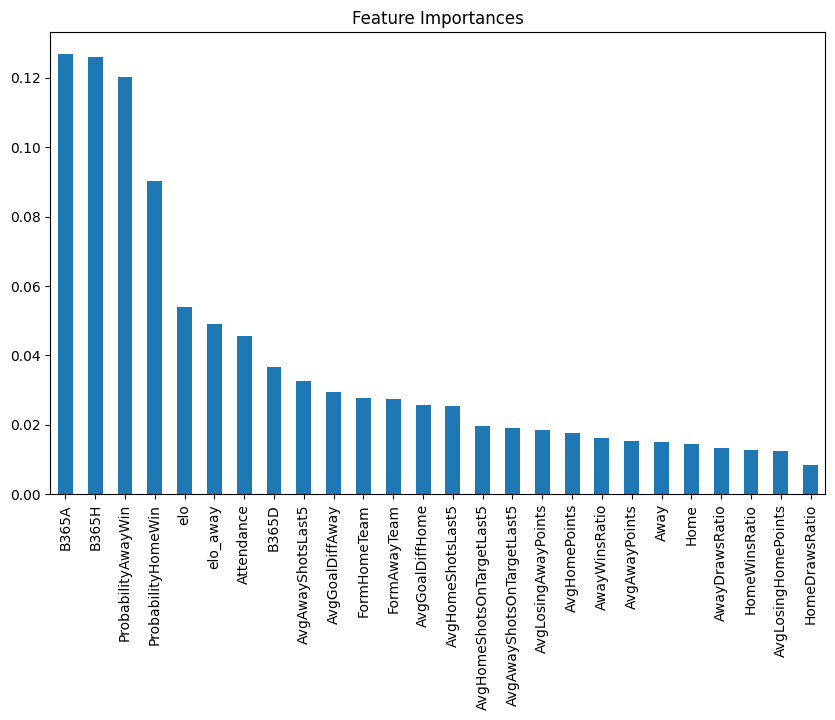

In [5]:
import matplotlib.pyplot as plt

# Extract feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()